In [ ]:
# %pip install opencv-python
# %pip install matplotlib

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
import os
import cv2
import math
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense

In [2]:
epochs = 4
image_size = 250

# Without Pertubations

In [3]:
train = ImageDataGenerator(rescale=1/255)
test = ImageDataGenerator(rescale=1/255)

train_dataset = train.flow_from_directory("preprocessing/train_data",
                                          target_size=(image_size,image_size),
                                          batch_size = 32,
                                          class_mode = 'binary')
                                         
test_dataset = test.flow_from_directory("preprocessing/val_data",
                                      target_size=(image_size,image_size),
                                      batch_size =32,
                                      class_mode = 'binary')

Found 602 images belonging to 2 classes.
Found 587 images belonging to 2 classes.


In [4]:
test_dataset.class_indices

{'female': 0, 'male': 1}

In [5]:
classifier = Sequential()

# Step 1 - Convolution
classifier.add(Convolution2D(32, 3, 3, input_shape = (image_size, image_size, 3), activation = 'relu'))

# Step 2 - Pooling
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a second convolutional layer
classifier.add(Convolution2D(32, 3, 3, activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Step 3 - Flattening
classifier.add(Flatten())

# Step 4 - Full connection
classifier.add(Dense(128, activation = 'relu'))
classifier.add(Dense(1, activation = 'sigmoid'))

# Compiling the CNN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [6]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   rotation_range=15,
                                   vertical_flip=True,
                                   fill_mode='reflect',
                                   data_format='channels_last',
                                   brightness_range=[0.5, 1.5],
                                   featurewise_center=True,
                                   featurewise_std_normalization=True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [35]:
early_stop = EarlyStopping(monitor='loss', min_delta=0.001, patience=3, mode='min', verbose=1)
checkpoint = ModelCheckpoint('model_best_weights.h5', monitor='loss', verbose=1, # Saves checkpoints
                             save_best_only=True, mode='min', period=1)
# Model weights are saved at the end of every epoch, if it's the best seen
# so far.
history = classifier.fit_generator(train_dataset,
         steps_per_epoch = 12,
         epochs = epochs,
         validation_data = test_dataset,
         callbacks = [early_stop,checkpoint]
         )

Epoch 1/4
12/12 [==============================] - ETA: 0s - loss: 0.3961 - accuracy: 0.8320
Epoch 00001: loss improved from inf to 0.39611, saving model to model_best_weights.h5
12/12 [==============================] - 3s 228ms/step - loss: 0.3961 - accuracy: 0.8320 - val_loss: 0.6474 - val_accuracy: 0.6661
Epoch 2/4
12/12 [==============================] - ETA: 0s - loss: 0.3520 - accuracy: 0.8530
Epoch 00002: loss improved from 0.39611 to 0.35203, saving model to model_best_weights.h5
12/12 [==============================] - 3s 223ms/step - loss: 0.3520 - accuracy: 0.8530 - val_loss: 0.7317 - val_accuracy: 0.6559
Epoch 3/4
12/12 [==============================] - ETA: 0s - loss: 0.3428 - accuracy: 0.8478
Epoch 00003: loss improved from 0.35203 to 0.34284, saving model to model_best_weights.h5
12/12 [==============================] - 3s 216ms/step - loss: 0.3428 - accuracy: 0.8478 - val_loss: 0.7101 - val_accuracy: 0.6422
Epoch 4/4
12/12 [==============================] - ETA: 0s - l

In [8]:
average_no_pert = sum(history.history['val_accuracy'])/epochs
print("Average Validation Accuracy Without Pertubations: ", average_no_pert)

Average Validation Accuracy Without Pertubations:  0.5310902893543243


# With Pertubations

In [9]:
train = ImageDataGenerator(rescale=1/255)
test = ImageDataGenerator(rescale=1/255)

train_dataset = train.flow_from_directory("preprocessing/makeup",
                                          target_size=(image_size,image_size),
                                          batch_size = 32,
                                          class_mode = 'binary')
                                         
test_dataset = test.flow_from_directory("preprocessing/val_data",
                                      target_size=(image_size,image_size),
                                      batch_size =32,
                                      class_mode = 'binary')

Found 445 images belonging to 2 classes.
Found 587 images belonging to 2 classes.


In [10]:
early_stop = EarlyStopping(monitor='loss', min_delta=0.001, patience=3, mode='min', verbose=1)
checkpoint = ModelCheckpoint('model_best_weights.h5', monitor='loss', verbose=1, 
                             save_best_only=True, mode='min', period=1)
# Model weights are saved at the end of every epoch, if it's the best seen
# so far.
history = classifier.fit_generator(train_dataset,
         steps_per_epoch = 12,
         epochs = epochs,
         validation_data = test_dataset,
         callbacks = [early_stop,checkpoint]
         )

Epoch 1/4
12/12 [==============================] - ETA: 0s - loss: 0.6798 - accuracy: 0.5853
Epoch 00001: loss improved from inf to 0.67978, saving model to model_best_weights.h5
12/12 [==============================] - 3s 229ms/step - loss: 0.6798 - accuracy: 0.5853 - val_loss: 0.6856 - val_accuracy: 0.5486
Epoch 2/4
12/12 [==============================] - ETA: 0s - loss: 0.6737 - accuracy: 0.5722
Epoch 00002: loss improved from 0.67978 to 0.67367, saving model to model_best_weights.h5
12/12 [==============================] - 3s 215ms/step - loss: 0.6737 - accuracy: 0.5722 - val_loss: 0.6823 - val_accuracy: 0.5758
Epoch 3/4
12/12 [==============================] - ETA: 0s - loss: 0.6662 - accuracy: 0.6042
Epoch 00003: loss improved from 0.67367 to 0.66624, saving model to model_best_weights.h5
12/12 [==============================] - 3s 228ms/step - loss: 0.6662 - accuracy: 0.6042 - val_loss: 0.6829 - val_accuracy: 0.5639
Epoch 4/4
12/12 [==============================] - ETA: 0s - l

In [11]:
average_pert = sum(history.history['val_accuracy'])/epochs
print("Average Validation Accuracy With Pertubations: ", average_pert)

Average Validation Accuracy With Pertubations:  0.5617546737194061


## Making predictions

In [31]:
def predictImage(filename):
    img1 = image.load_img(filename,target_size=(image_size,image_size))
    
    plt.imshow(img1)
 
    Y = image.img_to_array(img1)
    
    X = np.expand_dims(Y,axis=0)
    val = classifier.predict(X)
    print(val)
    if val == 1:
        plt.xlabel("MALE",fontsize=30)
    elif val == 0:
        plt.xlabel("FEMALE",fontsize=30)

[[1.]]


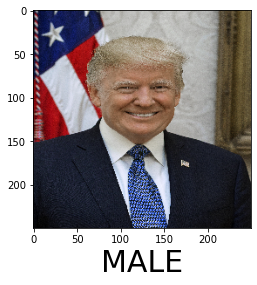

In [37]:
predictImage("trump.jpeg")

[[0.]]


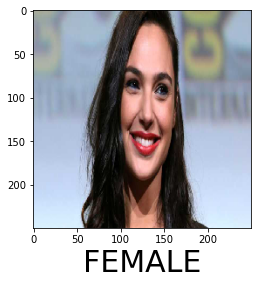

In [36]:
predictImage("gal.jpeg")

[[0.]]


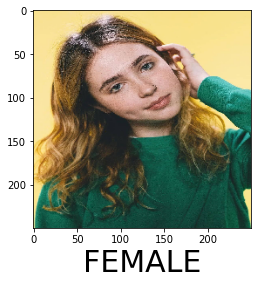

In [38]:
predictImage("clairo.jpeg")

# Model Evaluation

Text(0.5, 0, 'Epoch')

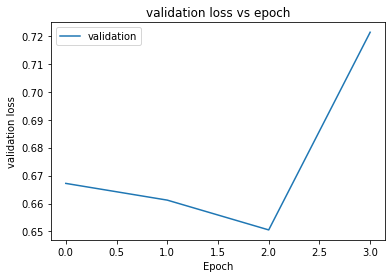

In [33]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(history.history['val_loss'])
plt.legend(['validation'], loc='upper left')
plt.title('validation loss vs epoch')
plt.ylabel('validation loss')
plt.xlabel('Epoch')

Text(0.5, 0, 'Epoch')

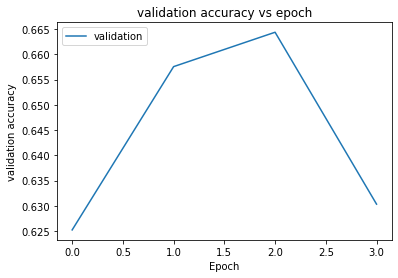

In [34]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(history.history['val_accuracy'])
plt.legend(['validation'], loc='upper left')
plt.title('validation accuracy vs epoch')
plt.ylabel('validation accuracy')
plt.xlabel('Epoch')